In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/question-pairs-dataset/questions.csv


In [2]:
df = pd.read_csv('/kaggle/input/question-pairs-dataset/questions.csv')

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404350 non-null  object
 4   question2     404349 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
df.duplicated().sum()

0

In [7]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

is_duplicate
0    255045
1    149306
Name: count, dtype: int64
is_duplicate
0    63.07515
1    36.92485
Name: count, dtype: float64


<Axes: xlabel='is_duplicate'>

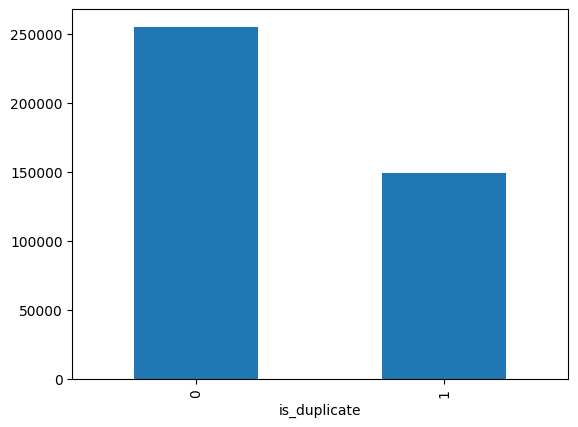

In [8]:
# distribution of duplicated and non duplicated pairs
print(df['is_duplicate'].value_counts())
print((df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100)
df['is_duplicate'].value_counts().plot(kind='bar')

In [9]:
new_df = df.sample(70000)

In [10]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }
    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [11]:
new_df['question1'] = new_df['question1'].apply(preprocess)
new_df['question2'] = new_df['question2'].apply(preprocess)

In [12]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
180008,180008,355554,355555,what is make money online,how can i earn money easily online,1
247236,247236,486852,486853,how can i start up a conversation with someone...,i can not start a conversation with a girl bec...,0
322746,322746,633122,633123,why girls height matters in indian culture,japanese culture is loaded with displays of re...,0
31497,31497,62786,62787,how do women feel about a guy that likes to be...,least square adjustment cons,0
268239,268239,527644,2854,why do you feel that the death penalty is cru...,is the death penalty cruel and unusual punishment,1


In [13]:
new_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

is_duplicate
0    44221
1    25779
Name: count, dtype: int64
is_duplicate
0    63.172857
1    36.827143
Name: count, dtype: float64


<Axes: xlabel='is_duplicate'>

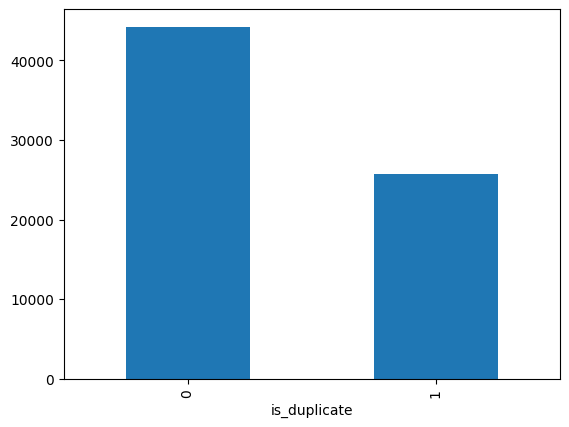

In [14]:
# distribution of duplicated and non duplicated pairs
print(new_df['is_duplicate'].value_counts())
print((new_df['is_duplicate'].value_counts()/new_df['is_duplicate'].count())*100)
new_df['is_duplicate'].value_counts().plot(kind='bar')

In [15]:
new_df['q1_len'] = new_df['question1'].str.len()
new_df['q2_len'] = new_df['question2'].str.len()

In [16]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len
180008,180008,355554,355555,what is make money online,how can i earn money easily online,1,25,34
247236,247236,486852,486853,how can i start up a conversation with someone...,i can not start a conversation with a girl bec...,0,62,116
322746,322746,633122,633123,why girls height matters in indian culture,japanese culture is loaded with displays of re...,0,42,240
31497,31497,62786,62787,how do women feel about a guy that likes to be...,least square adjustment cons,0,111,28
268239,268239,527644,2854,why do you feel that the death penalty is cru...,is the death penalty cruel and unusual punishment,1,70,49


In [17]:
# counting no. of words in question1 and question2
new_df['q1_words'] = new_df['question1'].apply(lambda row:len(row.split(" ")))
new_df['q2_words'] = new_df['question2'].apply(lambda row:len(row.split(" ")))

In [18]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_words,q2_words
180008,180008,355554,355555,what is make money online,how can i earn money easily online,1,25,34,5,7
247236,247236,486852,486853,how can i start up a conversation with someone...,i can not start a conversation with a girl bec...,0,62,116,12,24
322746,322746,633122,633123,why girls height matters in indian culture,japanese culture is loaded with displays of re...,0,42,240,7,44
31497,31497,62786,62787,how do women feel about a guy that likes to be...,least square adjustment cons,0,111,28,24,4
268239,268239,527644,2854,why do you feel that the death penalty is cru...,is the death penalty cruel and unusual punishment,1,70,49,14,8


In [19]:
# to find number of commomn words in the qustion1 and question2
def common_words(row):
    w1 = set(map(lambda word: word.strip(),row['question1'].split(" ")))
    w2 = set(map(lambda word: word.strip(),row['question2'].split(" ")))
    return len(w1 & w2)

In [20]:
new_df['word_common'] = new_df.apply(common_words,axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_words,q2_words,word_common
180008,180008,355554,355555,what is make money online,how can i earn money easily online,1,25,34,5,7,2
247236,247236,486852,486853,how can i start up a conversation with someone...,i can not start a conversation with a girl bec...,0,62,116,12,24,7
322746,322746,633122,633123,why girls height matters in indian culture,japanese culture is loaded with displays of re...,0,42,240,7,44,3
31497,31497,62786,62787,how do women feel about a guy that likes to be...,least square adjustment cons,0,111,28,24,4,0
268239,268239,527644,2854,why do you feel that the death penalty is cru...,is the death penalty cruel and unusual punishment,1,70,49,14,8,7


In [21]:
# total words
def total_words(row):
    w1 = set(map(lambda word: word.strip(),row['question1'].split(" ")))
    w2 = set(map(lambda word: word.strip(),row['question2'].split(" ")))
    return (len(w1) + len(w2))

In [22]:
new_df['word_total'] = new_df.apply(total_words,axis=1)
new_df["word_share"] = round(new_df["word_common"]/new_df["word_total"],2)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_words,q2_words,word_common,word_total,word_share
180008,180008,355554,355555,what is make money online,how can i earn money easily online,1,25,34,5,7,2,12,0.17
247236,247236,486852,486853,how can i start up a conversation with someone...,i can not start a conversation with a girl bec...,0,62,116,12,24,7,32,0.22
322746,322746,633122,633123,why girls height matters in indian culture,japanese culture is loaded with displays of re...,0,42,240,7,44,3,44,0.07
31497,31497,62786,62787,how do women feel about a guy that likes to be...,least square adjustment cons,0,111,28,24,4,0,26,0.00
268239,268239,527644,2854,why do you feel that the death penalty is cru...,is the death penalty cruel and unusual punishment,1,70,49,14,8,7,22,0.32


In [23]:
final_df = new_df.drop(columns = ['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(70000, 8)


,is_duplicate,q1_len,q2_len,q1_words,q2_words,word_common,word_total,word_share
180008,1,25,34,5,7,2,12,0.17
247236,0,62,116,12,24,7,32,0.22
322746,0,42,240,7,44,3,44,0.07
31497,0,111,28,24,4,0,26,0.00
268239,1,70,49,14,8,7,22,0.32


In [24]:
ques_df = new_df[["question1","question2"]]
ques_df.head()

,question1,question2
180008,what is make money online,how can i earn money easily online
247236,how can i start up a conversation with someone...,i can not start a conversation with a girl bec...
322746,why girls height matters in indian culture,japanese culture is loaded with displays of re...
31497,how do women feel about a guy that likes to be...,least square adjustment cons
268239,why do you feel that the death penalty is cru...,is the death penalty cruel and unusual punishment


In [25]:
from sklearn.feature_extraction.text import CountVectorizer

questions = list(ques_df["question1"]) + list(ques_df["question2"])

cv = CountVectorizer(max_features = 3000)

q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [26]:
temp_df1 = pd.DataFrame(q1_arr,index=ques_df.index)
temp_df2 = pd.DataFrame(q2_arr,index=ques_df.index)
temp_df = pd.concat([temp_df1,temp_df2],axis = 1)
temp_df.shape

(70000, 6000)

In [27]:
final_df = pd.concat([final_df,temp_df],axis = 1)
print(final_df.shape)
final_df.head()

(70000, 6008)


,is_duplicate,q1_len,q2_len,q1_words,q2_words,word_common,word_total,word_share,0,1,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
180008,1,25,34,5,7,2,12,0.17,0,0,...,0,0,0,0,0,0,0,0,0,0
247236,0,62,116,12,24,7,32,0.22,0,0,...,0,0,0,0,0,0,0,0,0,0
322746,0,42,240,7,44,3,44,0.07,0,0,...,0,0,0,0,0,0,0,0,0,0
31497,0,111,28,24,4,0,26,0.00,0,0,...,0,0,0,0,0,0,0,0,0,0
268239,1,70,49,14,8,7,22,0.32,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [29]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred)

0.7737142857142857

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7825714285714286